## Create quick voronoi diagrams using a geodataframe

This is a quick demonstration of using the metrica dataset inside a geodataframe. The key is that you can make the voronoi diagram a polygon based geodataframe, and then clip it to the outter edge of the pitch. 

I've also made it easy (for me at least) to load the tracking data into a geodataframe using my SpatialSoccer library. However, I have rearranged things from the original data. Instead of x,y columns for each player, I just made a continual list of points for each observation of a player. This includes a column for frame (if you want to get the position of all players at a certain timepoint), and a column for player (if you want to get all the positions for a player).

In [1]:

import numpy as np
import geopandas as gpd
from shapely.geometry.point import Point
from shapely.geometry import LineString
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from ssalib2 import SpatialSoccer

This loads the tracking data from metrica into a dataframe for Away and Home, then they are combined to the home team's geodataframe.

You could plot this (gdf.plot()) but it is over a million points to plot. This can then be fed into SciPy's voronoi or delaunay algorithms.

`ignore_ball` is so I don't duplicate the ball coordinates which is available in both datasets.

In [3]:
sa = SpatialSoccer()
agdf = sa.load_metrica_tracking("sample-data/data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv")
hgdf = sa.load_metrica_tracking("sample-data/data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv",ignore_ball=True)
gdf = hgdf.append(agdf,ignore_index=True,sort=False)
gdf.head()

,team,period,frame,x_coord,y_coord,time,point,playerid,geometry
0,Home,1,1,113.1300,39.6696,0.04,POINT Z (113.13 39.6696 0.04),Player_11,POINT Z (113.13000 39.66960 0.04000)
1,Home,1,1,77.7744,57.1160,0.04,POINT Z (77.7744 57.116 0.04),Player_1,POINT Z (77.77440 57.11600 0.04000)
2,Home,1,1,81.3024,45.7576,0.04,POINT Z (81.30240000000001 45.7576 0.04),Player_2,POINT Z (81.30240 45.75760 0.04000)
3,Home,1,1,83.8584,35.5152,0.04,POINT Z (83.8584 35.5152 0.04),Player_3,POINT Z (83.85840 35.51520 0.04000)
4,Home,1,1,77.2176,18.9976,0.04,POINT Z (77.2176 18.9976 0.04),Player_4,POINT Z (77.21760 18.99760 0.04000)


The points are extracted by the frame so that we can get all the players on the pitch. I also filter out the null points. I believe these are player substitutions. If you have too few points you can fake some by appending the corners of the pitch.

scipy.spatial.Voronoi creates the voronoi lines (not polygons). 

In [4]:
from scipy.spatial import Delaunay
from scipy.spatial import Voronoi
#points = np.append(gdf.loc[(gdf["frame"]==51)&(gdf['x_coord'].notnull()),['x_coord','y_coord']].values,[[0,0],[120,0],[120,80],[0,80]],axis=0)
points = gdf.loc[(gdf["frame"]==51)&(gdf['x_coord'].notnull())&(gdf['playerid']!="Ball"),['x_coord','y_coord']].values
vor = Voronoi(points)

The lines from the voronoi result is extracted and then added to a geodataframe as lines. Then using the pitch from SpatialSoccer I intersected the voronoi lines giving me voronoi polygons that fall within the pitch itself.

In [5]:

lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
index_list = [i for i in range(0,len(lines))]
vor_gdf = gpd.GeoDataFrame({"order":index_list},geometry=lines)
pitchgdf = SpatialSoccer.build_polygon_pitch_statsbomb()
p = pitchgdf.iloc[0]['geometry']
vor_gdf['clipped'] = vor_gdf['geometry'].apply(lambda x: p.intersection(x))
vor_gdf=vor_gdf.set_geometry(vor_gdf['clipped'])



Finally, the player positions, voronoi polygons, and pitch are plotted. I iterated to add the text and points of positions at the same time.

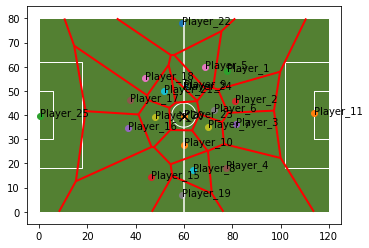

In [6]:
ax = pitchgdf.plot(facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);
ax.set_xlim([-5,125])
ax.set_ylim([-5,85])
for i,row in gdf.loc[(gdf["frame"]==51)&(gdf['x_coord'].notnull())].iterrows():
    
    if row['playerid'] == 'Ball':
        ax.scatter(row['x_coord'],row['y_coord'],label=row['playerid'],color="Black",marker="x",zorder=3,s=100)
        #ax.text(row['x_coord'],row['y_coord'],row['playerid'])
    else:
        ax.scatter(row['x_coord'],row['y_coord'],label=row['playerid'])
        ax.text(row['x_coord'],row['y_coord'],row['playerid'])
    
vor_gdf.plot(ax=ax,linewidth=2,color='red');

### Home vs Away Voronoi

We can compare the spaces occupied by the home and away teams. I wrapped the above in a function to make it easier.



In [7]:
def build_voronoi_from_points(points,pitch_geometry):
    vor = Voronoi(points)
    lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
    index_list = [i for i in range(0,len(lines))]
    vor_gdf = gpd.GeoDataFrame({"order":index_list},geometry=lines)
    vor_gdf['clipped'] = vor_gdf['geometry'].apply(lambda x: pitch_geometry.intersection(x))
    vor_gdf=vor_gdf.set_geometry(vor_gdf['clipped'])
    return vor_gdf

ball


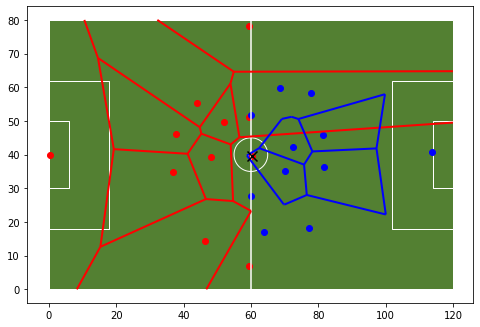

In [8]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111)
points_h = hgdf.loc[(hgdf["frame"]==51)&(hgdf['x_coord'].notnull()),['x_coord','y_coord']].values
vor_h_gdf = build_voronoi_from_points(points_h, pitchgdf.iloc[0]['geometry'])
points_a = agdf.loc[(agdf["frame"]==51)&(agdf['x_coord'].notnull()),['x_coord','y_coord']].values
vor_a_gdf = build_voronoi_from_points(points_a, pitchgdf.iloc[0]['geometry'])

pitchgdf.plot(ax = ax, facecolor = SpatialSoccer.GREEN_PITCH_COLOR,edgecolor=SpatialSoccer.WHITE_LINE_COLOR);

for i,row in agdf.loc[(agdf["frame"]==51)&(agdf['x_coord'].notnull())].iterrows():
    if row['playerid'] == 'Ball':
        print("ball")
        ax.scatter(row['x_coord'],row['y_coord'],label=row['playerid'],color="Black",marker="x",zorder=3,s=100)
        #ax.text(row['x_coord'],row['y_coord'],row['playerid'])
    else:
        ax.scatter(row['x_coord'],row['y_coord'],label=row['playerid'],color="red")
        #ax.text(row['x_coord'],row['y_coord'],row['playerid'])
for i,row in hgdf.loc[(hgdf["frame"]==51)&(hgdf['x_coord'].notnull())].iterrows():
    ax.scatter(row['x_coord'],row['y_coord'],label=row['playerid'],color="blue")
    #ax.text(row['x_coord'],row['y_coord'],row['playerid'])
vor_a_gdf.plot(ax=ax,linewidth=2,color='red');
vor_h_gdf.plot(ax=ax,linewidth=2,color='blue');